# Classification model for chess squares

# Imports

In [1]:
import os
import cv2
import numpy as np
import json
import mlflow

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pathlib

import matplotlib.pyplot as plt

from torchinfo import summary
import torchvision.transforms as transforms
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

import mlflow.pytorch
import mlflow

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)
import seaborn as sns

from pprint import pprint

# Device

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple GPU
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


# Dataset class

In [4]:
class Chess2dRenderedDataset(Dataset):
    def __init__(self, imgs_dir, labels_dir, class2id):
        self.imgs_dir = imgs_dir
        self.labels_dir = labels_dir
        
        self.board_img_paths = [os.path.join(imgs_dir, img) for img in sorted(os.listdir(imgs_dir))]
        self.labels_paths = [os.path.join(labels_dir, label) for label in sorted(os.listdir(labels_dir))]
        self.samples = []
        
        for img_path, label_path in zip(self.board_img_paths, self.labels_paths):
            # 64 squares per image
            for row in range(8):
                for col in range(8):
                    self.samples.append((img_path, label_path, row, col))
                    
                    
        self.transform = transforms.ToTensor() # Convert images to tensors (0-255 -> 0-1)
        
        self.class2id = class2id # Dictionary mapping class names to IDs
                    
        
    def __len__(self):
        return len(self.samples)
    
    
    def __getitem__(self, idx):
        img_path, label_path, row, col = self.samples[idx]
        
        # Constants
        SQUARE_SIZE = 60
        BOARD_PADDING = 0 # Percentage of padding around the square
        
        # Load the image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        
        # Crop the board padding
        h, w = img.shape[:2]
        start_h = int(h * BOARD_PADDING // 100)
        start_w = int(w * BOARD_PADDING // 100)
        img = img[start_h:h-start_h, start_w:w-start_w]
        
        # Crop the specific square
        img = cv2.resize(img, (8 * SQUARE_SIZE, 8 * SQUARE_SIZE))
        square_img = img[row*SQUARE_SIZE:(row+1)*SQUARE_SIZE, col*SQUARE_SIZE:(col+1)*SQUARE_SIZE]
        
        # Load the label
        with open(label_path, 'r') as f:
            label_arr = np.loadtxt(f, delimiter=',', dtype=str)
            
        square_label = label_arr[row, col]
        
        # Move the channel dimension to the front
        #square_img = np.transpose(square_img, (1, 2, 0)) # Dont need (transoform already does this)
        
        square_img_tensor = self.transform(square_img)  # Convert to tensor (3, 60, 60)
        
        # Convert label to class ID
        square_label = self.class2id.get(square_label, -1)  # Use -1 for unknown labels
        
        return square_img_tensor, square_label
    

try:
    # This works in .py files
    base_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # Fallback for Jupyter notebooks
    base_dir = os.getcwd()

#DATASET_NAME = "chessboard_2d_rendered"
DATASET_NAME = "chessboard_2d_rendered_aug"
#save_dir = pathlib.Path(base_dir).parent / "data" / "chessboard_2d_rendered"
save_dir = pathlib.Path(base_dir).parent / "data" / DATASET_NAME
labels_mapping_path = save_dir / "labels_mapping.json"

with open(labels_mapping_path, 'r') as f:
    labels_map = json.load(f)


train_imgs_dir = save_dir / "train" / "images"
train_labels_dir = save_dir / "train" / "labels"

train_dataset = Chess2dRenderedDataset(
    imgs_dir=train_imgs_dir,
    labels_dir=train_labels_dir,
    class2id=labels_map["class2id"]
)

test_imgs_dir = save_dir / "test" / "images"
test_labels_dir = save_dir / "test" / "labels"
test_dataset = Chess2dRenderedDataset(
    imgs_dir=test_imgs_dir,
    labels_dir=test_labels_dir,
    class2id=labels_map["class2id"]
)

validation_imgs_dir = save_dir / "validation" / "images"
validation_labels_dir = save_dir / "validation" / "labels"  

validation_dataset = Chess2dRenderedDataset(
    imgs_dir=validation_imgs_dir,
    labels_dir=validation_labels_dir,
    class2id=labels_map["class2id"]
)
    
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")
print(f"Number of validation samples: {len(validation_dataset)}")

Number of training samples: 41472
Number of testing samples: 5056
Number of validation samples: 8128


### Sample example

Sample image shape: torch.Size([3, 60, 60])
Sample label: 11
Sample image numpy shape: (3, 60, 60)
Sample image numpy transposed shape: (60, 60, 3)


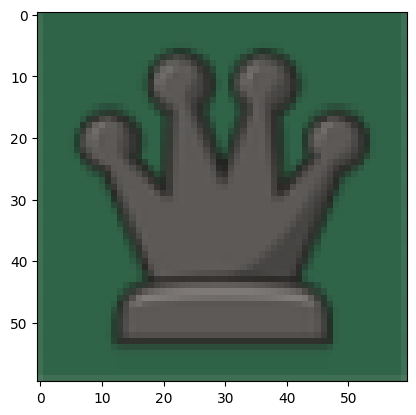

In [7]:
sample_img, sample_label = validation_dataset[3]

print(f"Sample image shape: {sample_img.shape}")
print(f"Sample label: {sample_label}")

img_np = sample_img.numpy()
print(f"Sample image numpy shape: {img_np.shape}")
img_np = np.transpose(img_np, (1, 2, 0))  # Move channels to last dimension for plotting
print(f"Sample image numpy transposed shape: {img_np.shape}")

plt.imshow(img_np)

# Data loader

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle= True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle= True)
validation_dataloader = DataLoader(validation_dataset, batch_size=64, shuffle= True)

train_imgs_batch, train_labels_batch = next(iter(train_dataloader))
print(f"Batch image shape: {train_imgs_batch.shape}")
print(f"Batch labels shape: {len(train_labels_batch)}")

print(train_labels_batch)

Batch image shape: torch.Size([64, 3, 60, 60])
Batch labels shape: 64
tensor([ 4,  0,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,
         9,  0,  0,  2,  4,  0,  7,  0, 11,  0,  0,  4,  0,  0,  0,  0,  0,  0,
         0,  0,  6,  0,  0,  2,  6,  0,  0,  2, 10,  0,  0,  0,  4,  0,  2, 10,
         6, 10,  0,  0,  0, 10,  6,  3,  0,  0])


# Classification model

## Dimensions

- Convolution without stride:
    $$
    Out = (W_{in} + 2P) - K + 1
    $$
- Convolution with stride
    $$
    Out = \left\lfloor \frac{W_{in} + 2P - K}{S} \right\rfloor + 1
    $$

## AlexNet
Consists of eight hidden layers with ReLU activation functions of which the first 5 are convolutional and the rest fully connected. 

![Architecture](images/alexnet.png)

- Input shape: (224, 224, 3)
- Conv-1 11x11 (Stride 4): (55, 55, 96)
- MaxPool
- Conv-2 5x5: (27, 27, 256)
- MaxPool
- Conv-3 3x3: (13, 13, 384)
- Conv-4 3x3: (13, 13, 384)
- Conv-5 3x3: (13, 13, 256)
- MaxPool: (6, 6, 256)
- Flatten: (9216)
- Fully Connected: 4096
- Fully Connected: 4096
- Fully Connected: 1000
- Softmax: (1000)


In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2), # (55, 55, 96)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # (27, 27, 96)
            nn.Conv2d(96, 256, kernel_size=5, padding=2), # (27, 27, 256)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # (13, 13, 256)
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1), # (13, 13, 384)
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1), # (13, 13, 384)
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1), # (13, 13, 256)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2) # (6, 6, 256) = 9216 features
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.flatten(1)
        x = self.classifier(x)
        return x
    
summary(AlexNet(), input_size=(64, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [64, 1000]                --
├─Sequential: 1-1                        [64, 256, 6, 6]           --
│    └─Conv2d: 2-1                       [64, 96, 55, 55]          34,944
│    └─ReLU: 2-2                         [64, 96, 55, 55]          --
│    └─MaxPool2d: 2-3                    [64, 96, 27, 27]          --
│    └─Conv2d: 2-4                       [64, 256, 27, 27]         614,656
│    └─ReLU: 2-5                         [64, 256, 27, 27]         --
│    └─MaxPool2d: 2-6                    [64, 256, 13, 13]         --
│    └─Conv2d: 2-7                       [64, 384, 13, 13]         885,120
│    └─ReLU: 2-8                         [64, 384, 13, 13]         --
│    └─Conv2d: 2-9                       [64, 384, 13, 13]         1,327,488
│    └─ReLU: 2-10                        [64, 384, 13, 13]         --
│    └─Conv2d: 2-11                      [64, 256, 13, 13]      

## Small AlexNet for chess squares

In [14]:
class SmallAlexNet(nn.Module):
    def __init__(self, num_classes=13, input_size=(3, 60, 60)):
        super(SmallAlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=1, padding=2), # (54, 54, 96)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # (26, 26, 96)
            nn.Conv2d(96, 256, kernel_size=5, padding=2), # (26, 26, 256)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # (12, 12, 256)
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1), # (12, 12, 384)
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1), # (12, 12, 384)
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1), # (12, 12, 256)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2) # (5, 5, 256) = 6400 features
        )
        
        with torch.no_grad():
            # Calculate the output size after the feature extractor
            sample_input = torch.zeros(1, *input_size)
            output_features_shape = self.features(sample_input).shape[1:]
            
        output_features_size = np.prod(output_features_shape)
        print("Output features size:", output_features_shape)
        print("Output features size:", output_features_size)
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(output_features_size, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.flatten(1)
        x = self.classifier(x)
        return x
    
model = SmallAlexNet(num_classes=13, input_size=(3, 60, 60))
summary(model)

Output features size: torch.Size([256, 5, 5])
Output features size: 6400


Layer (type:depth-idx)                   Param #
SmallAlexNet                             --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       34,944
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       614,656
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
│    └─Conv2d: 2-7                       885,120
│    └─ReLU: 2-8                         --
│    └─Conv2d: 2-9                       1,327,488
│    └─ReLU: 2-10                        --
│    └─Conv2d: 2-11                      884,992
│    └─ReLU: 2-12                        --
│    └─MaxPool2d: 2-13                   --
├─Sequential: 1-2                        --
│    └─Dropout: 2-14                     --
│    └─Linear: 2-15                      26,218,496
│    └─ReLU: 2-16                        --
│    └─Dropout: 2-17                     --
│    └─Linear: 2-18                  

In [15]:
X, y = next(iter(train_dataloader))
print(f"Input batch shape: {X.shape} {type(X)}")
print(f"Labels batch shape: {len(y)} {type(y[0])}")

print(y[0:3])

y_pred = model(X)
print(f"Predicted batch shape: {y_pred.shape}")
print(y_pred[0])

Input batch shape: torch.Size([64, 3, 60, 60]) <class 'torch.Tensor'>
Labels batch shape: 64 <class 'torch.Tensor'>
tensor([0, 0, 0])
Predicted batch shape: torch.Size([64, 13])
tensor([ 0.0167, -0.0084,  0.0027,  0.0059,  0.0028, -0.0104, -0.0044, -0.0021,
         0.0076, -0.0059,  0.0107, -0.0038,  0.0077],
       grad_fn=<SelectBackward0>)


# Training

In [16]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    model.train() # Set model to training mode
    
    train_loss, correct = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
        # Log progress every 10 batches
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
            
    avg_train_loss = train_loss / len(dataloader)
    train_accuracy = correct / size
    
    return avg_train_loss, train_accuracy
            
            
def test_loop(dataloader, model, loss_fn, device):
    model.eval()  # Set model to evaluation mode
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X) # Get logits (no probabilities)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    avg_test_loss = test_loss / num_batches
    test_accuracy = correct / size
    
    print(f"Test Error: Accuracy: {avg_test_loss:.4f}, Avg loss: {avg_test_loss:.4f} \n")
    
    return avg_test_loss, test_accuracy
    
    
def train_model(model, train_dataloader, test_dataloader, device, num_epochs=10, learning_rate=1e-3):
    loss_fn = nn.CrossEntropyLoss() # Applies softmax so no need to do add softmax to the model output
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Log hyperparameters
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("learning_rate", learning_rate)

    # Best model accuracy
    best_test_accuracy = 0.0

    #for epoch in tqdm(range(num_epochs), desc="Training"):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1:>4d}/{num_epochs:>4d}\n-------------------------------")

        avg_train_loss, avg_train_accuracy = train_loop(train_dataloader, model, loss_fn, optimizer, device)
        avg_test_loss, avg_test_accuracy = test_loop(test_dataloader, model, loss_fn, device)

        print(f"Avg Train Loss: {avg_train_loss:.4f}, Avg Test Loss: {avg_test_loss:.4f}")
        print(f"Avg Train Accuracy: {avg_train_accuracy:.4f}, Avg Test Accuracy: {avg_test_accuracy:.4f}\n")
        
        # Log metrics for each epoch
        mlflow.log_metric("avg_train_loss", avg_train_loss, step=epoch)
        mlflow.log_metric("avg_test_loss", avg_test_loss, step=epoch)
        mlflow.log_metric("train_accuracy", avg_train_accuracy, step=epoch)
        mlflow.log_metric("test_accuracy", avg_test_accuracy, step=epoch)

        # Save best model
        if avg_test_accuracy > best_test_accuracy:
            best_test_accuracy = avg_test_accuracy
            mlflow.pytorch.log_model(model, "best_model")
            print(f"Best model updated at epoch {epoch+1} with test accuracy {best_test_accuracy:.4f}")

    # Log the trained model
    mlflow.pytorch.log_model(model, "last_model")

    print("Done!")
    
# def train_model(model, train_dataloader, test_dataloader, device, num_epochs=10, learning_rate=1e-3):
#     loss_fn = nn.CrossEntropyLoss() # Applies softmax so no need to do add softmax to the model output
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#     #for epoch in tqdm(range(num_epochs), desc="Training"):
#     for epoch in range(num_epochs):
#         print(f"Epoch {epoch+1:>4d}/{num_epochs:>4d}\n-------------------------------")

#         avg_train_loss, avg_train_accuracy = train_loop(train_dataloader, model, loss_fn, optimizer, device)
#         avg_test_loss, avg_test_accuracy = test_loop(test_dataloader, model, loss_fn, device)

#         print(f"Avg Train Loss: {avg_train_loss:.4f}, Avg Test Loss: {avg_test_loss:.4f}")
#         print(f"Avg Train Accuracy: {avg_train_accuracy:.4f}, Avg Test Accuracy: {avg_test_accuracy:.4f}\n")
    
#     print("Done!")

- [MLflow documentation](https://mlflow.org/docs/latest/ml/deep-learning/pytorch/)

In [17]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple GPU
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

# Set experiment
mlflow.set_experiment("Chess2dRenderedModelAug")

# Set save directory
current_dir = pathlib.Path.cwd()
base_dir = current_dir.parent
mlruns_dir = base_dir / "data" / "mlruns"
print("Mlruns dir: ", mlruns_dir)
mlflow.set_tracking_uri("file://" + str(mlruns_dir))

# Training and logging
with mlflow.start_run():

    # Create and prepare model
    model = model.to(device)

    # Train the model
    train_model(model, train_dataloader, test_dataloader, device = device, num_epochs=3, learning_rate=1e-3)

Using device: mps
Mlruns dir:  /Users/alexquiroga/Storage/Github/DEEP_LEARNING/COMPUTER_VISION/chess-vision/chess-main/data/mlruns
Epoch    1/   3
-------------------------------
loss: 2.554519 [    0/41472]
loss: 2.302640 [  640/41472]
loss: 1.613847 [ 1280/41472]
loss: 1.190234 [ 1920/41472]
loss: 1.487871 [ 2560/41472]
loss: 0.974674 [ 3200/41472]
loss: 0.983069 [ 3840/41472]
loss: 0.753405 [ 4480/41472]
loss: 0.788526 [ 5120/41472]
loss: 0.600410 [ 5760/41472]
loss: 0.611601 [ 6400/41472]
loss: 0.670959 [ 7040/41472]
loss: 0.712028 [ 7680/41472]
loss: 0.742381 [ 8320/41472]
loss: 0.614939 [ 8960/41472]
loss: 0.413227 [ 9600/41472]
loss: 0.313324 [10240/41472]
loss: 0.222872 [10880/41472]
loss: 0.207201 [11520/41472]
loss: 0.255803 [12160/41472]
loss: 0.193713 [12800/41472]
loss: 0.158506 [13440/41472]
loss: 0.311465 [14080/41472]
loss: 0.159136 [14720/41472]
loss: 0.206450 [15360/41472]
loss: 0.366396 [16000/41472]
loss: 0.220850 [16640/41472]
loss: 0.248554 [17280/41472]
loss: 0.1

2025/08/14 23:04:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Test Error: Accuracy: 0.2965, Avg loss: 0.2965 

Avg Train Loss: 0.3469, Avg Test Loss: 0.2965
Avg Train Accuracy: 0.9003, Avg Test Accuracy: 0.9096



2025/08/14 23:04:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best model updated at epoch 1 with test accuracy 0.9096
Epoch    2/   3
-------------------------------
loss: 0.268683 [    0/41472]
loss: 0.163630 [  640/41472]
loss: 0.112111 [ 1280/41472]
loss: 0.046267 [ 1920/41472]
loss: 0.029746 [ 2560/41472]
loss: 0.006650 [ 3200/41472]
loss: 0.000096 [ 3840/41472]
loss: 0.014914 [ 4480/41472]
loss: 0.031630 [ 5120/41472]
loss: 0.003216 [ 5760/41472]
loss: 0.001702 [ 6400/41472]
loss: 0.037729 [ 7040/41472]
loss: 0.001873 [ 7680/41472]
loss: 0.040028 [ 8320/41472]
loss: 0.013858 [ 8960/41472]
loss: 0.006063 [ 9600/41472]
loss: 0.000102 [10240/41472]
loss: 0.017643 [10880/41472]
loss: 0.002187 [11520/41472]
loss: 0.018431 [12160/41472]
loss: 0.056624 [12800/41472]
loss: 0.034350 [13440/41472]
loss: 0.004563 [14080/41472]
loss: 0.001700 [14720/41472]
loss: 0.000032 [15360/41472]
loss: 0.020470 [16000/41472]
loss: 0.053258 [16640/41472]
loss: 0.042266 [17280/41472]
loss: 0.000053 [17920/41472]
loss: 0.016878 [18560/41472]
loss: 0.000018 [19200/4147

2025/08/14 23:09:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Test Error: Accuracy: 0.0006, Avg loss: 0.0006 

Avg Train Loss: 0.0218, Avg Test Loss: 0.0006
Avg Train Accuracy: 0.9937, Avg Test Accuracy: 1.0000



2025/08/14 23:09:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best model updated at epoch 2 with test accuracy 1.0000
Epoch    3/   3
-------------------------------
loss: 0.000004 [    0/41472]
loss: 0.017510 [  640/41472]
loss: 0.015021 [ 1280/41472]
loss: 0.000000 [ 1920/41472]
loss: 0.005602 [ 2560/41472]
loss: 0.000031 [ 3200/41472]
loss: 0.000007 [ 3840/41472]
loss: 0.000577 [ 4480/41472]
loss: 0.001655 [ 5120/41472]
loss: 0.000004 [ 5760/41472]
loss: 0.000163 [ 6400/41472]
loss: 0.000122 [ 7040/41472]
loss: 0.002824 [ 7680/41472]
loss: 0.000000 [ 8320/41472]
loss: 0.000021 [ 8960/41472]
loss: 0.000029 [ 9600/41472]
loss: 0.000011 [10240/41472]
loss: 0.000094 [10880/41472]
loss: 0.000103 [11520/41472]
loss: 0.000011 [12160/41472]
loss: 0.000000 [12800/41472]
loss: 0.000003 [13440/41472]
loss: 0.000026 [14080/41472]
loss: 0.000081 [14720/41472]
loss: 0.005841 [15360/41472]
loss: 0.000107 [16000/41472]
loss: 0.004443 [16640/41472]
loss: 0.000746 [17280/41472]
loss: 0.002430 [17920/41472]
loss: 0.001555 [18560/41472]
loss: 0.000584 [19200/4147

2025/08/14 23:15:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Test Error: Accuracy: 0.0000, Avg loss: 0.0000 

Avg Train Loss: 0.0023, Avg Test Loss: 0.0000
Avg Train Accuracy: 0.9994, Avg Test Accuracy: 1.0000



2025/08/14 23:15:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Done!


# Test model

In [18]:
#DATASET_NAME = "chessboard_2d_rendered"
DATASET_NAME = "chessboard_2d_rendered_aug"

current_dir = pathlib.Path.cwd()
base_dir = current_dir.parent
dataset_dir = base_dir / "data" / DATASET_NAME
labels_mapping_path = dataset_dir / "labels_mapping.json"

with open(labels_mapping_path, 'r') as f:
    labels_map = json.load(f)

id2label = labels_map["id2class"]

# Convert keys to int
id2label = {int(k): v for k, v in id2label.items()}

pprint(id2label)

class_names = [id2label[i] for i in sorted(id2label.keys())]

pprint(class_names)

{0: '0',
 1: 'B',
 2: 'K',
 3: 'N',
 4: 'P',
 5: 'Q',
 6: 'R',
 7: 'b',
 8: 'k',
 9: 'n',
 10: 'p',
 11: 'q',
 12: 'r'}
['0', 'B', 'K', 'N', 'P', 'Q', 'R', 'b', 'k', 'n', 'p', 'q', 'r']


Single chessboard and no blur dataset model

In [18]:
# Load model from mlflow
mlruns_dir = str(pathlib.Path.cwd().parent / "data" / "mlruns")
mlflow.set_tracking_uri("file://" + mlruns_dir)
run_id = "4deab14be91f40289414ecd5304923e6"
model = mlflow.pytorch.load_model("runs:/" + run_id + "/best_model")

Multiple chessboards and blur dataset model

In [19]:
# Load model from mlflow
mlruns_dir = str(pathlib.Path.cwd().parent / "data" / "mlruns")
mlflow.set_tracking_uri("file://" + mlruns_dir)
run_id = "36aa38a2ba8a41a5841265e48c030eea"
model = mlflow.pytorch.load_model("runs:/" + run_id + "/best_model")

/Users/alexquiroga/anaconda3/envs/computer_vision/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple GPU
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3028
           1       1.00      1.00      1.00       139
           2       1.00      1.00      1.00        79
           3       1.00      1.00      1.00       101
           4       1.00      1.00      1.00       490
           5       1.00      1.00      1.00        66
           6       1.00      1.00      1.00       141
           7       1.00      1.00      1.00       128
           8       1.00      1.00      1.00        79
           9       1.00      1.00      1.00        82
          10       1.00      1.00      1.00       516
          11       1.00      1.00      1.00        79
          12       1.00      1.00      1.00       128

    accuracy                           1.00      5056
   macro avg       1.00      1.00      1.00      5056
weighted avg       1.00      1.00      1.00

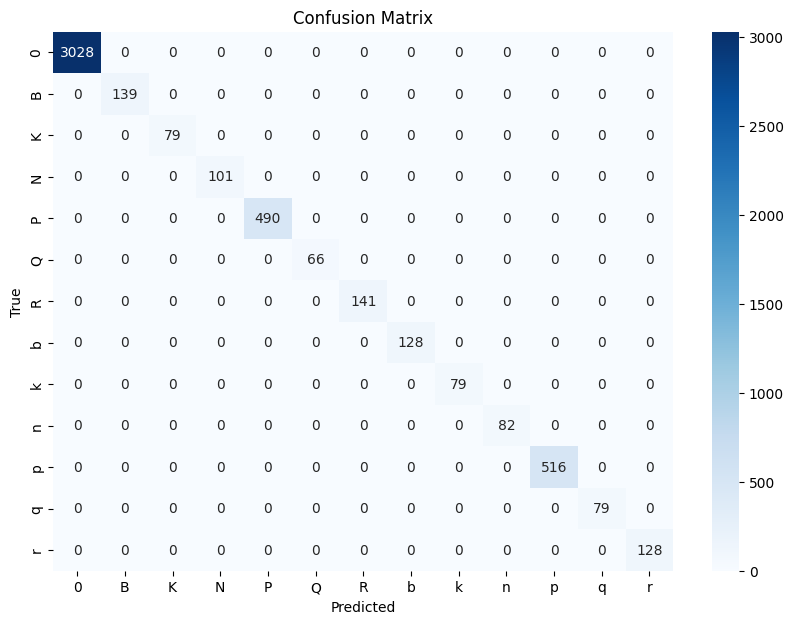

In [21]:
all_preds = []
all_labels = []

for batch, (X_test, y_test) in enumerate(test_dataloader):
    X_test, y_test = X_test.to(device), y_test.to(device)
    y_pred = model(X_test)
    y_pred = y_pred.argmax(dim=1)

    all_preds.extend(y_pred.cpu().numpy())
    all_labels.extend(y_test.cpu().numpy())

# Compute accuracy
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

cm = confusion_matrix(all_labels, all_preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("Classification report: ")
print(classification_report(all_labels, all_preds))

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()